In [27]:
import pandas as pd
import AnalFunctions as af
import numpy as np
import matplotlib.pyplot as plt
import os

path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var, test_var2, test_str2, lin_var, T_test_list, sec_test_var, N_ped, fps, mot_frac = af.var_ini()
af.file_writer(path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var)

sl = "/"
T_test_list = lin_var[test_var2]
lattice_type = 'jule'
runs_tested = N_runs
traj_testvar2 = []


def dist(x1, y1, x2, y2, x3, y3): # x3,y3 is the point

    px = x2-x1
    py = y2-y1

    norm = px*px + py*py

    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(norm)

    #u_new = np.array([1 if ui > 1 else 0 for ui in u])
    u[u > 1] = 1
    u[u < 0] = 0

    x = x1 + u * px
    y = y1 + u * py

    dx = x - x3
    dy = y - y3

    # Note: If the actual distance does not matter,
    # if you only want to compare what this function
    # returns to other results of this function, you
    # can just return the squared distance instead
    # (i.e. remove the sqrt) to gain a little performance

    dist = np.sqrt(dx*dx + dy*dy)
    return dist



current path is  trajectories/ini_lm_N_ped55_tmax2600_size_0_17_fps_16_testvar_b/
0    0.1
1    1.3
2    0.1
3    1.3
4    0.1
5    1.3
6    0.1
7    1.3
8    0.1
9    1.3
Name: T, dtype: float64
[0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3]
[[ 0.7   0.6   1.34  0.1   3.6  55.    1.    0.25]
 [ 0.7   0.6   1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   1.15  1.34  0.1   3.6  55.    1.    0.25]
 [ 0.7   1.15  1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   1.7   1.34  0.1   3.6  55.    1.    0.25]
 [ 0.7   1.7   1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   2.25  1.34  0.1   3.6  55.    1.    0.25]
 [ 0.7   2.25  1.34  1.3   3.6  55.    1.    0.25]
 [ 0.7   2.8   1.34  0.1   3.6  55.    1.    0.25]
 [ 0.7   2.8   1.34  1.3   3.6  55.    1.    0.25]]
   Unnamed: 0                                         ini_folder     b    v0  \
0           0  ini_0_6_lm_55_esigma_0_7_tmax_2600_periodic_0_...  0.60  1.34   
1           1  ini_0_6_lm_55_esigma_0_7_tmax_2600_periodic_0_...  0.60  1.34   
2          

/writing files


In [28]:
waittime_list = []
test_var_list = []
test_var2_list = []
b_list = []
N_ped_list = []
T_list = []
os.system("mkdir " + path + "waittime")
t_min = 10
t_max = 30
t_start = t_min * fps
t_end = t_max * fps


In [29]:
from multiprocessing import Pool


<calculating b = 1.2>


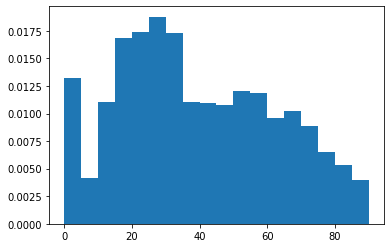

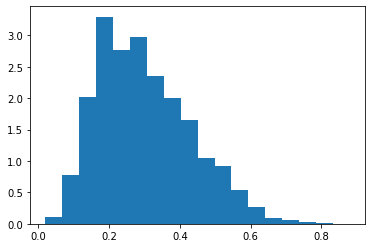

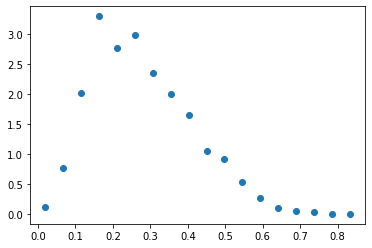

0.3011127417503378
39.44588105032861
<calculating b = 2.3>


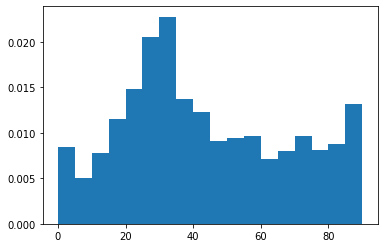

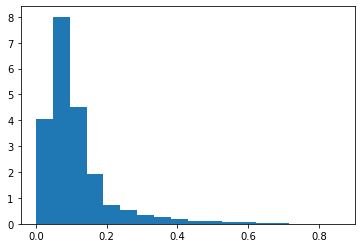

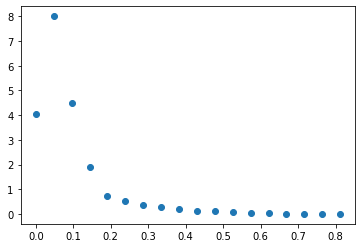

0.1105255703286596
43.619963402977774
<calculating b = 3.4>


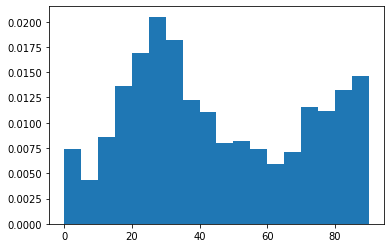

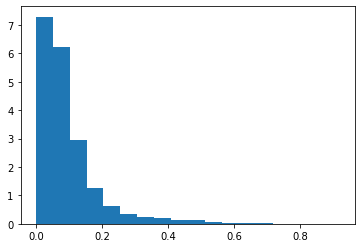

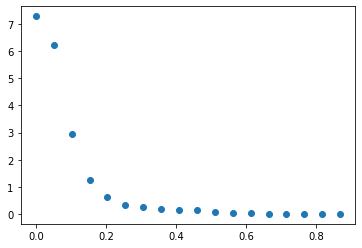

0.09852315252742615
45.169142519384174
<calculating b = 4.5>


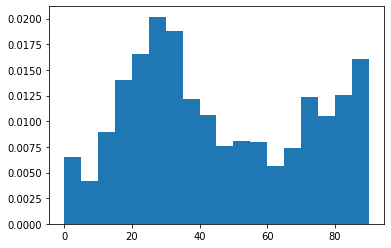

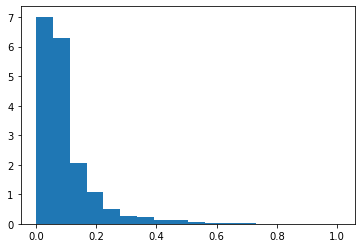

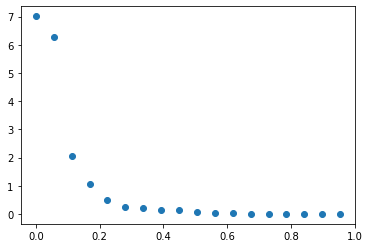

0.0965188601925093
45.57656285615948
<calculating b = 5.6>


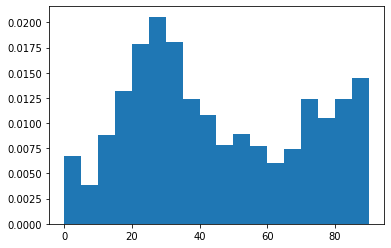

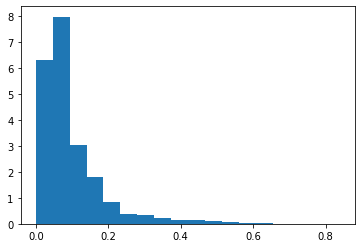

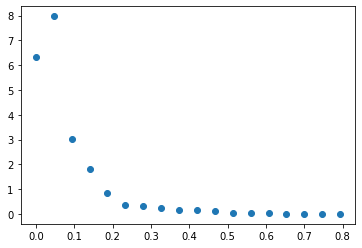

0.09562851224062355
45.25976978853892


In [33]:
col = ["FR","X","Y","ID","speed_nn","ANGLE_int_nn"]
blist = 2 * lin_var[test_var]
v_0_list = []
for T_test in T_test_list[1:2]:
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])

    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    
    v_0_mean = np.empty(blist.shape[0])
    v_0_var = np.empty(blist.shape[0])
    angle_nn_mean = np.empty(blist.shape[0])
    for loc_list_runs in loc_list:
        print("<calculating " + test_str + " = " + str(2 * lin_var[test_var][bi]) + ">")
        v_nn_mean = np.empty(0)
        angle_nn = np.empty(0)
        
        for loc in loc_list_runs:
            if os.path.isfile(loc) == False:
                print("WARNING: file " + loc + " not found.")
                continue
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            #df['ANGLE_int_nn'] = df['ANGLE_int_nn'].values.astype(np.float) 
            df = df[df['ANGLE_int_nn'].values.astype(np.float) >= 0.0]
            df = df[df['speed_nn'].values.astype(np.float) >= 0.0]
            df = df[df['speed_nn'].values.astype(np.float) < 1.34]

            df = df[df['FR'] > fps * 10]
            df = df[df['Y'] > 0]
            df = df[df['X'] * df['X'] + df['Y']* df['Y'] < 1.]
            v_nn_mean = np.append(v_nn_mean,df['speed_nn'].values.astype(np.float))
            
            #df = df[abs(df['X']) < 0.5]
            #df = df[df['Y'] > 1]

            #df = df[df['Y'] < 1]

            angle_nn = np.append(angle_nn,np.arccos(df['ANGLE_int_nn'].values.astype(np.float))*180./3.1415)

        #plt.hist(v_nn_mean,bins=50)
        #plt.show()
    
        x, bins, p= plt.hist(angle_nn,bins=18,density=True)        
        plt.show()
        
        x, bins, p =plt.hist(v_nn_mean,bins = 18,density=True)
        plt.show()

        nphist = np.histogram(v_nn_mean,bins=18,density = True)
        #plt.plot(nphist[1][:-1],np.log(-np.log(1-nphist[0])), marker = "o", linestyle='none')
        plt.plot(nphist[1][:-1],nphist[0], marker = "o", linestyle='none')
        #plt.xscale("log")
        #plt.yscale("log")
        plt.show()
        #print(v_nn_mean)
        v_0_list.append(v_nn_mean.mean())
        v_0_mean[bi] = v_nn_mean.mean()
        v_0_var[bi] = v_nn_mean.std()
        print(v_nn_mean.mean())
        angle_nn_mean[bi] = angle_nn.mean()
        print(angle_nn.mean())
        bi += 1
        #print(v_nn_mean.mean())


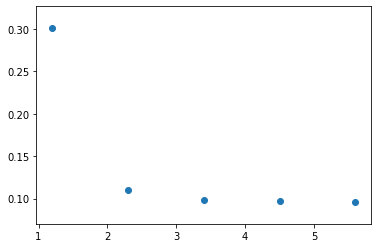

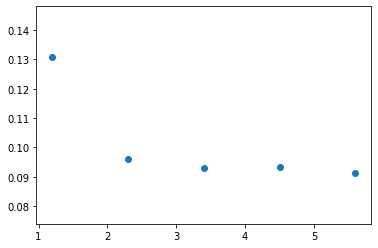

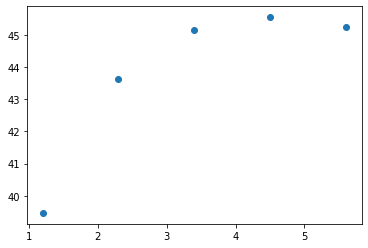

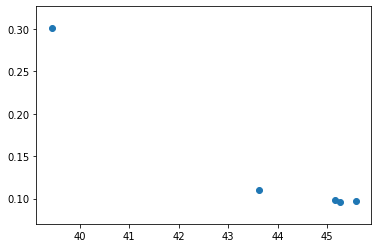

In [34]:
#plt.yscale("exp")
#plt.xscale("log")
plt.scatter(blist,v_0_mean)

plt.show()

plt.scatter(blist,v_0_var)
plt.show()
plt.scatter(blist,angle_nn_mean)
plt.show()

plt.scatter(angle_nn_mean,v_0_mean)

plt.show()


<calculating b = 0.55>


/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


</calculating b = 0.55>


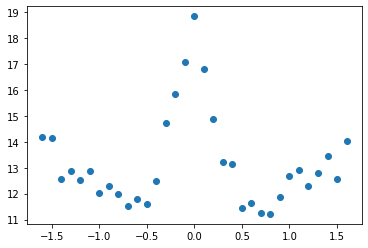

In [45]:
col = ["FR","X","Y","ID"]
t_array = np.arange(t_start, 100 * fps, int(fps/2 ))#
for T_test in T_test_list[0:1]:
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])

    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    bi = 0
    ttt_arr = np.empty(0)
    dist_arr = np.empty(0)
    angle_arr = np.empty(0)
    x_ar = np.empty(0)
    y_ar = np.empty(0)
    for loc_list_runs in loc_list[-2:-1]:
        print("<calculating " + test_str + " = " + str(lin_var[test_var][bi]) + ">")

        for loc in loc_list_runs:
            df = pd.read_csv(loc, sep="\s+", header=0, comment="#",skipinitialspace=True, usecols=col)
            min_value = df.groupby('ID')['Y'].min()[df['ID']][0:N_ped - 1]
            #n_max_frame = df.groupby('ID')['FR'].max()[df['ID']][0:N_ped - 1].nlargest(12).index.values
            #print(n_max_frame)
            min_value = min_value[min_value < -0.2]
            key_filtered = min_value.keys().values
            
            df = df[df['ID'].isin(key_filtered)]
            df = df[df['Y'] > 0.]
            df = df[~df['ID'].isin(n_max_frame)]
            
            max_frame = df.groupby('ID')['FR'].max()[df['ID']]
            #print(max_frame.groupby('ID').nlargest(1))
            df['max_frame'] = max_frame.values
            df = df[df['FR'].isin(t_array)]

            #print(max_frame)


            x = df['X'].values
            y = df['Y'].values
            #dist_ttt = np.round(dist(-0.4, 0., 0.4, 0., x, y),2)
            dist_ttt = np.round(np.sqrt( x * x + y * y),1)
            angle_ttt = np.round(np.arctan(y/x),1)
            ttt = df['max_frame'].values - df['FR'].values
            ttt_arr = np.append(ttt_arr,ttt)
            dist_arr = np.append(dist_arr,dist_ttt)
            angle_arr = np.append(angle_arr,angle_ttt)
            x_ar = np.append(x_ar,x)
            y_ar = np.append(y_ar,y)
        print("</calculating " + test_str + " = " + str(lin_var[test_var][bi]) + ">")
        #print(dist_ttt.shape)
        #print(ttt.shape)
        #print(np.array(ttt_arr))
        df_plot = pd.DataFrame({"ttt" :  ttt_arr  / fps,"angle":angle_arr, "dist": dist_arr,"x":x_ar,"y":y_ar })
        #plt.plot(dist_arr,ttt_arr/fps,marker = "o",linestyle='none')
        #print(df_plot)
        #print(df_plot)
        bi += 1
        df_mean = df_plot[df_plot["dist"] < 1.2]
        df_mean = df_mean[df_mean["dist"] > 1.0]

        df_mean = df_mean.groupby("angle").mean()
        #print(df_mean)
        plt.plot(df_mean.index,df_mean["ttt"],marker = "o",linestyle='none')
        #plt.xscale('log')
        #plt.yscale('log')
        plt.show()
        #plt.plot(df_plot["dist"].values, ttt_mean_list,marker = "o",linestyle='none')
   # plt.show()


In [35]:
"""theta = df_plot['angle'].values
r = df_plot['dist'].values
ttt = df_plot['ttt'].values

x_arr = r * np.cos(theta)
y_arr = r * np.sin(theta)

x, y = np.meshgrid(x_arr, y_arr)
ttt_mesh = np.meshgrid(ttt,ttt)
z = ttt_mesh[:-1, :-1].flatten()

z_min, z_max = np.abs(z).min(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='hot', vmin=z_min, vmax=12, label="density in [m^-2]")
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax, label="$\\rho$ in [$m^{-2}$]")
print(z.mean())
print("corridor width = ", bi)
if bi == 1.7 or bi == 1.2:
    print("density jump")
line_width = 2.5
add_wall(line_width,bi*2)
name_var = lin_var[test_var][test_var_count]
test_var_count += 1"""

'theta = df_plot[\'angle\'].values\nr = df_plot[\'dist\'].values\nttt = df_plot[\'ttt\'].values\n\nx_arr = r * np.cos(theta)\ny_arr = r * np.sin(theta)\n\nx, y = np.meshgrid(x_arr, y_arr)\nttt_mesh = np.meshgrid(ttt,ttt)\nz = ttt_mesh[:-1, :-1].flatten()\n\nz_min, z_max = np.abs(z).min(), np.abs(z).max()\nfig, ax = plt.subplots()\nc = ax.pcolormesh(x, y, z, cmap=\'hot\', vmin=z_min, vmax=12, label="density in [m^-2]")\n# set the limits of the plot to the limits of the data\nax.axis([x.min(), x.max(), y.min(), y.max()])\nfig.colorbar(c, ax=ax, label="$\\rho$ in [$m^{-2}$]")\nprint(z.mean())\nprint("corridor width = ", bi)\nif bi == 1.7 or bi == 1.2:\n    print("density jump")\nline_width = 2.5\nadd_wall(line_width,bi*2)\nname_var = lin_var[test_var][test_var_count]\ntest_var_count += 1'

In [36]:
"""df_plot['x']= np.round(x_arr,1)
df_plot['y']= np.round(y_arr,1)
df_heat = pd.DataFrame({"x":np.round(x_arr,1),"y":np.round(y_arr,1),"ttt":ttt_arr/fps})"""

'df_plot[\'x\']= np.round(x_arr,1)\ndf_plot[\'y\']= np.round(y_arr,1)\ndf_heat = pd.DataFrame({"x":np.round(x_arr,1),"y":np.round(y_arr,1),"ttt":ttt_arr/fps})'

In [46]:
x_arr = np.round(np.arange(-3.5,3.5,0.1),1)
y_arr = np.round(np.arange(0,10,0.1),1)


In [56]:
ttt_arr = np.zeros([y_arr.shape[0],x_arr.shape[0]])
df_plot2 = df_plot
df_plot2['x'] = np.round(df_plot2['x'].values,1)
df_plot2['y'] = np.round(df_plot2['y'].values,1)

x_i = 0
for x in x_arr:
    y_i = 0
    for y in y_arr:
        x_bool = df_plot2['x'] == x
        df_new = df_plot2[x_bool]
        y_bool = df_new['y'] == y

        df_new = df_new[y_bool]
        #print(df_new['ttt'].values.shape[0])
        if (df_new['ttt'].values.shape[0]  and x*x + y*y < 4 and x*x + y * y > 0.09):
            ttt_arr[y_i][x_i] += df_new['ttt'].values.sum()/df_new['ttt'].values.shape[0]
            
        y_i += 1
    x_i += 1


In [57]:
print(x_arr.shape,y_arr.shape)
ttt_arr.shape

(70,) (100,)


(100, 70)

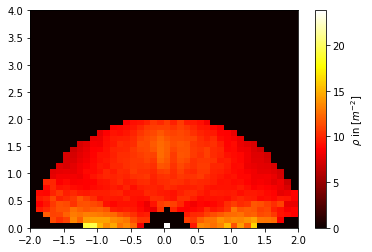

In [58]:
x, y = np.meshgrid(x_arr, y_arr)

r = x * x + y * y


z = np.divide(ttt_arr,r, where= r != 0)

#z = ttt_arr
#z = r
#print(z[z > 0])
z_min, z_max = np.abs(z).min(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='hot', vmin=z_min, vmax=z_max, label="density in [m^-2]")
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
plt.xlim([-2,2])
plt.ylim([0,4])
fig.colorbar(c, ax=ax, label="$\\rho$ in [$m^{-2}$]")
#print(z.mean())
#print("corridor width = ", bi)
#if bi == 1.7 or bi == 1.2:
#    print("density jump")
#line_width = 2.5
#add_wall(line_width,bi*2)
#name_var = lin_var[test_var][test_var_count]
#test_var_count += 1

In [190]:
np.arccos(np.array([0.1,0.5,0.7,-1]))

array([1.47062891, 1.04719755, 0.79539883, 3.14159265])

In [22]:
if 1 - 1:
    print(1)

In [19]:
import pandas as pd
from matplotlib import pyplot as plt
import math as m
import os
from multiprocessing import Pool
import random as rd
from pathlib import Path
import sys
from scipy.integrate import simps
import itertools
import AnalFunctions as af
from shapely.geometry import Point, Polygon
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

def exp_plot(exp_dens,mot,c):
    b22 = [1.2,2.3,3.4,4.5,4.5,5.6,5.6]

    p1 = np.array(exp_dens['p025'])
    p2 = np.array(exp_dens['p975'])
    mean_exp =  np.array(exp_dens['mean'])
    plt.errorbar(b22,mean_exp,yerr =[mean_exp - p1, p2 - mean_exp], label = "Experimental results " + mot, color = c,fmt='o')

def wallbuilder(b):
    wall_lx = np.empty(100)
    wall_lx.fill(-2 * b)
    wall_ly = np.linspace(0, 15, 100)
    wall_l = np.array([np.array([xi, yi]) for xi, yi in zip(wall_lx, wall_ly)])

    wall_rx = np.empty(100)
    wall_rx.fill(2 * b)

    wall_bx = np.array([i for i in np.arange(-b, b, 0.1) if abs(i) > 0.25])
    wall_by = np.empty(wall_bx.shape)
    wall_by.fill(-4)
    wall_b = np.array([np.array([xi, yi]) for xi, yi in zip(wall_bx, wall_by)])
    wall_ry = np.linspace(0, 15, 100)
    wall_r = np.array([np.array([xi, yi]) for xi, yi in zip(wall_rx, wall_ry)])
    wall = np.vstack((wall_l, wall_r))
    wall = np.vstack((wall, wall_b))
    return wall

def room_geo(b):
    #coords = [(-0.25,-1), (-0.25,-0.15),(-0.4,0),(-b/2,0),(-b/2,5),(b/2,5),(b/2,0),(0.4,0), (0.25,-0.15),(0.25,-1)]
    coords = [(0, 0), (-b / 2, 0), (-b / 2, 15), (b / 2, 15), (b / 2, 0), (0.0, 0)]

    poly_room = Polygon(coords)
    return poly_room

def measure_area(x_min,x_max,y_min,y_max):
    measure_poly = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)])
    return measure_poly

def vor_dens(lat, poly_room, wall,measure_poly):

    lat = np.array([point for point in lat if Point(point[0], point[1]).within(poly_room)])
    if lat.shape[0] == 0:
        return
    lat = np.vstack((lat, wall))
    vor = Voronoi(lat)
    vert = vor.regions
    rig_vert = []
    for note in vert:
        if -1 in note:
            continue
        rig_vert.append(note)

    measure_area = measure_poly.area
    densty = []

    for note in rig_vert[1:]:
        coords = [(vor.vertices[i][0], vor.vertices[i][1]) for i in note]
        poly = Polygon(coords)
        intersec = poly.intersection(poly_room)
        if intersec.is_empty:
            continue
        poly = intersec
        pol_area = poly.area
        solution = measure_poly.intersection(poly)
        if pol_area > 0:
            densty.append(solution.area * 1 / pol_area)
    densty = np.array(densty)

    return densty.sum() / measure_area

In [15]:
path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var, test_var2, test_str2, lin_var, T_test_list, sec_test_var, N_ped, fps, mot_frac = af.var_ini()
af.file_writer(path, folder_list, N_runs, b, cross_var, folder_frame, test_str, test_var)


file_path = "../../expdata/"
sl = "/"
os.system("mkdir " + path + "plots/heatmaps")
os.system("mkdir " + path + "density")

lattice_type = 'jule'
traj_testvar2 = []
print(test_str2 + " " , lin_var[test_var2])
runs_tested = N_runs
col = ["FR","X","Y"]
"""for T_test in lin_var[test_var2]:
    print(T_test)
    folder_frame_frac = folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'].to_numpy()
    b_folder = folder_frame.loc[folder_frame[test_str2] == T_test]['b'].to_numpy()

    if test_str2 != 'b':
        b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])
    else:
        b_folder = T_test

    print(b_folder)

    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi,3) + "_" + str(i) + ".txt" for i in range(runs_tested)] for folder,bi in zip(folder_frame_frac,b_folder)]
    print(np.array(loc_list).shape)
    print("load trajectories " + str(T_test))
    trajectory_frame = [[pd.read_csv(loc, sep="\s+", header=0, comment = "#",usecols = col) for loc in loc_list_runs if os.path.isfile(loc)] for loc_list_runs in loc_list]
    #print(trajectory_frame)
    traj_testvar2.append(trajectory_frame)
    print("/load trajectories")"""

current path is  trajectories/ini_lm_N_ped55_tmax2500_size_0_17_fps_16_testvar_b/
0      0.1
1      1.3
2      0.1
3      1.3
4      0.1
      ... 
121    1.3
122    0.1
123    1.3
124    0.1
125    1.3
Name: T, Length: 126, dtype: float64
[0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3
 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3
 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3
 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3
 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3
 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3
 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3 0.1 1.3]
[[ 0.7   0.4   1.34 ... 55.    1.    0.25]
 [ 0.7   0.4   1.34 ... 55.    1.    0.25]
 [ 0.7   0.45  1.34 ... 55.    1.    0.25]
 ...
 [ 0.7   3.45  1.34 ... 55.    1.    0.25]
 [ 0.7   3.5   1.34 ... 55.    1.    0.25]
 [ 0.7   3.5   1.34 ... 55. 

/writing files
T  [0.1 1.3]


'for T_test in lin_var[test_var2]:\n    print(T_test)\n    folder_frame_frac = folder_frame.loc[folder_frame[test_str2] == T_test][\'ini_folder\'].to_numpy()\n    b_folder = folder_frame.loc[folder_frame[test_str2] == T_test][\'b\'].to_numpy()\n\n    if test_str2 != \'b\':\n        b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test][\'b\'])\n    else:\n        b_folder = T_test\n\n    print(b_folder)\n\n    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi,3) + "_" + str(i) + ".txt" for i in range(runs_tested)] for folder,bi in zip(folder_frame_frac,b_folder)]\n    print(np.array(loc_list).shape)\n    print("load trajectories " + str(T_test))\n    trajectory_frame = [[pd.read_csv(loc, sep="\\s+", header=0, comment = "#",usecols = col) for loc in loc_list_runs if os.path.isfile(loc)] for loc_list_runs in loc_list]\n    #print(trajectory_frame)\n    traj_testvar2.append(trajectory_frame)\n    print("/load trajectories")'

In [16]:
fps = 16
fps_step = 8
k = 0
#shape = 50
dens_name = []
dens_name_ini = []
testvar2_list = []
testvar_list = []
#b_list_list = [[0.6,0.6,0.6,0.6],[1.15,1.15,1.15,1.15],[1.7,1.7,1.7,1.7],[2.8,2.8,2.8,2.8]]
#b_list_list = np.array([[0.6,0.6],[2.8,2.8]])
test_var_shape = lin_var[test_var].shape[0]
#b_np = np.empty(test_var_shape)
#b_list_list = np.empty()
if test_str2 == 'b':
    b_list_list = np.array([lin_var[test_var2] for i in range(test_var_shape)])
if test_str == 'b':
    b_list_list = np.array([b_folder for i in range(lin_var[test_var2].shape[0])])
else:
    b_list_list = np.array([np.full(test_var_shape, lin_var[test_var2][0]) for i in range(test_var_shape)])
#b_list_list = [b_folder]
print("b_folder = ", b_folder)
min_t = int(fps * 10)
max_t = int(min_t + fps * 5)

b_folder =  [0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05
 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75
 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45
 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15
 3.2  3.25 3.3  3.35 3.4  3.45 3.5 ]


In [26]:
for T_test in T_test_list:
    folder_frame_frac = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['ini_folder'])
    b_folder = np.array(folder_frame.loc[folder_frame[test_str2] == T_test]['b'])

    loc_list = [[path + folder + sl + "new_evac_traj_" + af.b_data_name(2 * bi, 3) + "_" + str(i) + ".txt" for i in
                 range(runs_tested)] for folder, bi in zip(folder_frame_frac, b_folder)]
    for loc_list_runs in loc_list:
        flat_list = np.empty((lin_var[test_var].shape[0],N_runs))

        flat_list = np.empty((lin_var[test_var].shape[0],N_runs))
        #dens_new_list = np.empty((lin_var[1].shape[0],N_runs,shape))
        print(flat_list.shape)
        #bi_count = 0
        vor_mean01 = []
        j = 0
        print(b_folder)
        #bi = 2 * lin_var[1][bi_count]
        #bi_count += 1
        density_list = []
        density_list_ini = []
        df_dens = pd.DataFrame()
        df_dens_ini = pd.DataFrame()

        print(test_str, " = ",str(lin_var[test_var][j]), test_str2 , " = ",str(lin_var[test_var2][k]) )
        #if lin_var[test_var][j] != 1.0:
            #continue
        measure_poly = measure_area(-0.4, 0.4, 0.5, 1.3)
        print("*****************<calc density>*****************")
        for loc,bi in zip(loc_list_runs,2 * b_folder):
            #print(loc)
            if os.path.isfile(loc) == False:
                print("file " + loc + " is missing")
                continue
            print(loc)
            traj_i = pd.read_csv(loc, sep="\s+", header=0, comment="#", skipinitialspace=True, usecols = col)
            print(traj_i)
            print(bi)
            wall = wallbuilder(bi)
            room = room_geo(bi)
            densty = []
            density_ini = []
            frame_array = np.arange(0, traj_i['FR'].max(), fps_step)
            for i in frame_array:
                x_list = np.array(traj_i[traj_i['FR'] == i]['X'])
                y_list = np.array(traj_i[traj_i['FR'] == i]['Y'])
                lattice = np.array([np.array([xi, yi]) for xi, yi in zip(x_list, y_list)])
                if int(i) == 0:
                    print(bi)
                    d_ini = vor_dens(lattice,room,wall,measure_area(-bi/2,bi/2,0,7))
                    print(d_ini)
                    density_ini.append(d_ini)
                di = vor_dens(lattice, room, wall, measure_poly)
                densty.append(di)
            density_list.append(np.array(densty))
            density_list_ini.append(np.array(density_ini))
            t_array = [i / fps for i in frame_array]
            print("*****************</calc density>*****************")

            # plt.show()
            density_np = np.array(density_list)
            density_np_ini = np.array(density_list_ini)
            dens_length = np.empty((N_runs))
            print(density_np.shape)
            for d,i in zip(density_np,range(density_np.shape[0])):
                dens_length[i] = d.shape[0]
            shape = int(dens_length.min())
            #dens_new = np.empty((N_runs, shape))

            dens_mean = np.empty(density_np.shape[0])
            dens_mean_ini = np.empty(density_np_ini.shape[0])
            print(shape)
            for d,i in zip(density_np,range(density_np.shape[0])):
                dens_mean[i] = d[int(min_t / fps_step): int(max_t / fps_step)].mean()
                #i += 1
                df_dens[str(i)] = d[0:shape]
            j += 1


(63, 10)
[0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05
 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75
 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35 2.4  2.45
 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1  3.15
 3.2  3.25 3.3  3.35 3.4  3.45 3.5 ]
b  =  0.4 T  =  0.1
*****************<calc density>*****************
trajectories/ini_lm_N_ped55_tmax2500_size_0_17_fps_16_testvar_b/ini_0_4_lm_55_esigma_0_7_tmax_2500_periodic_0_v0_1_34_T_0_1_rho_ini_3_6_Nped_55_0_motfrac_1_0/new_evac_traj_0_8_0.txt
          FR     X      Y
0        0.0 -0.05  14.40
1        0.0 -0.05  10.20
2        0.0 -0.05   6.00
3        0.0 -0.05   3.90
4        0.0 -0.05   1.10
...      ...   ...    ...
15717  549.0 -0.03  -0.75
15718  550.0  0.01  -0.80
15719  551.0  0.01  -0.83
15720  552.0 -0.01  -0.91
15721  553.0 -0.02  -0.96

[15722 rows x 3 columns]
0.8
0.8
3.635204081632653
*****************</calc density>*****************
(1, 7

/Users/jonas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice.


ValueError: cannot convert float NaN to integer